<a href="https://colab.research.google.com/github/shiling2007/Python-/blob/main/survival_model_likelihood_estimator_add_SASPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 

from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# files.download('/content/drive/MyDrive/Colab Notebooks/Lease Payment Formula.ipynb') 
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 999)
pd.set_option("max_colwidth", 500)
# try:
#  device_name = os.environ['COLAB_TPU_ADDR']
#  TPU_ADDRESS = 'grpc://' + device_name
#  print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#  print('TPU not found')
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install lifelines

     |████████████████████████████████| 348 kB 6.0 MB/s 
     |████████████████████████████████| 55 kB 1.1 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=536940855840048b94bea2d4452bb427e53f9dccc05f5562ae4a47c007aa2d3e
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [3]:
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels import api
from scipy.optimize import minimize
from scipy.stats import norm, uniform
from statsmodels.formula.api import probit
from lifelines import (KaplanMeierFitter, WeibullFitter,  NelsonAalenFitter, PiecewiseExponentialFitter, LogLogisticFitter, LogNormalFitter, CoxPHFitter, ExponentialFitter)
from scipy.stats import weibull_min, expon, randint , lognorm, norm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#survival data generation

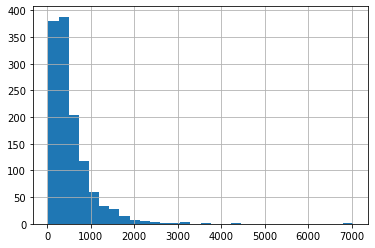

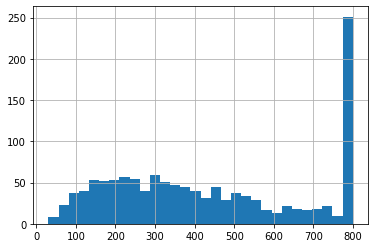

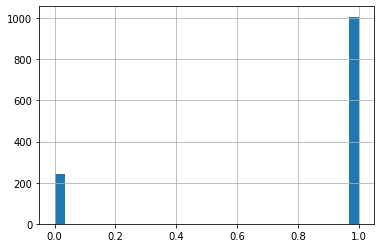

In [5]:
n_obs=1250
censored=800
loc=6.0; scale=0.8;

days=np.exp(norm.rvs(loc=loc, scale=scale, size=n_obs, random_state=123))
days_censored=np.minimum(days, censored)
event=np.where(days_censored==censored, 0,1)

data=pd.DataFrame(np.c_[days,days_censored,event], columns=['days','days_censored','event'])
data.days.hist(bins=30)
plt.show()
data.days_censored.hist(bins=30)
plt.show()
data.event.hist(bins=30)


<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 1250 total observations, 243 right-censored observations>


<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 1250 total observations, 243 right-censored observations>
   number of observations = 1250
number of events observed = 1007
           log-likelihood = -7204.240
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%       z       p   -log2(p)
mu_     5.981      0.023            5.936            6.027 255.821 <0.0005        inf
sigma_  0.803      0.019            0.767            0.840 -10.471 <0.0005     82.812
---
AIC = 14412.481

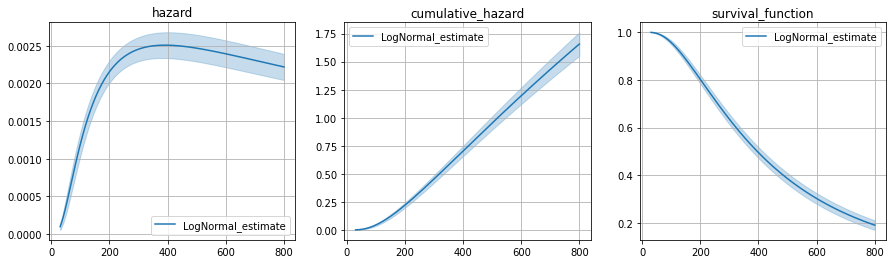

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
lnf = LogNormalFitter().fit(data["days_censored"], data["event"])
print(lnf)
lnf.plot_hazard(ax=ax[0], grid=True)
lnf.plot_cumulative_hazard(ax=ax[1], grid=True)
lnf.plot_survival_function(ax=ax[2], grid=True)
ax[0].set_title("hazard"); ax[1].set_title("cumulative_hazard"); ax[2].set_title("survival_function")

lnf.print_summary(3)

In [7]:
data

,days,days_censored,event
0,169.270075,169.270075,1.0
1,895.942608,800.000000,0.0
2,505.922147,505.922147,1.0
3,120.900057,120.900057,1.0
4,253.945531,253.945531,1.0
...,...,...,...
1245,170.184385,170.184385,1.0
1246,191.876095,191.876095,1.0
1247,224.957459,224.957459,1.0
1248,256.997036,256.997036,1.0


In [8]:
#lognormal survival distribution
def _ll_survival(y, beta, censored):
    mu=beta[0]
    sigma=beta[1]
    # X=np.where(y==censored, 0, 1)
    Y=np.log(y)
    pdf=norm.pdf(Y,  loc=mu, scale=sigma)
    cdf=norm.cdf(Y,  loc=mu, scale=sigma)   
    prob=(y<censored)*pdf + (y>=censored)*(1-cdf)
    ll=np.log(prob)
    return ll.sum() 

class MySurvical_mle(GenericLikelihoodModel):
    def __init__(self, endog, exog=None,  **kwds):
      super(MySurvical_mle, self).__init__(endog, exog,  **kwds)

    def nloglikeobs(self, params):
	    beta = params
	    ll = _ll_survival(self.endog, beta, censored)
	    return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
    # we have one additional parameter and we need to add it for summary
      # self.exog_names.append('mu') ;self.exog_names.append('sigma');
      if start_params == None:
        # start_params =np.array([0.5,2,0,1,4,2])
        start_params =np.array([1,1])
        return super(MySurvical_mle, self).fit(start_params=start_params, maxiter=maxiter, maxfun=maxfun,  **kwds)

y=data.days_censored
X=data.event
model_survival=MySurvical_mle(y).fit()
print(model_survival.summary())
print(model_survival.params)

Optimization terminated successfully.
         Current function value: 1.167510
         Iterations: 56
         Function evaluations: 108
                            MySurvical_mle Results                            
Dep. Variable:          days_censored   Log-Likelihood:                -1459.4
Model:                 MySurvical_mle   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Wed, 22 Dec 2021                                         
Time:                        17:50:05                                         
No. Observations:                1250                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [9]:
def _ll_survival(y, beta, censored):
    mu=beta[0]
    sigma=beta[1]
    # X=np.where(y==censored, 0, 1)
    Y=np.log(y)
    pdf=norm.pdf(Y,  loc=mu, scale=sigma)
    cdf=norm.cdf(Y,  loc=mu, scale=sigma)   
    prob=(y<censored)*pdf + (y>=censored)*(1-cdf)
    ll=np.log(prob)
    return ll.sum() 
y=data.days_censored
X=data.event
beta= model_survival.params

ll= _ll_survival(y,  beta, censored)


print(ll)

-1459.3868817443938


In [10]:
#lognormal survival distribution
def _ll_survival(y, beta,censored):
    mu=beta[0]
    sigma=beta[1]
    # X=np.where(y==censored, 0, 1)
    # Y=np.log(y)
    pdf=lognorm.pdf(y ,sigma, loc=0, scale=np.exp(mu))
    cdf=lognorm.cdf(y, sigma, loc=0, scale=np.exp(mu))   
    prob=(y<censored)*pdf + (y>=censored)*(1-cdf)
    ll=np.log(prob)
    return ll.sum() 

class MySurvical_mle(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
      super(MySurvical_mle, self).__init__(endog, exog,  **kwds)

    def nloglikeobs(self, params):
	    beta = params
	    ll = _ll_survival(self.endog, beta,censored)
	    return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
    # we have one additional parameter and we need to add it for summary
      # self.exog_names.append('mu') ;self.exog_names.append('sigma');
      if start_params == None:
        # start_params =np.array([0.5,2,0,1,4,2])
        start_params =np.array([1,1])
        return super(MySurvical_mle, self).fit(start_params=start_params, maxiter=maxiter, maxfun=maxfun,  **kwds)

y=data.days_censored
X=data.event
model_survival=MySurvical_mle(y).fit()
print(model_survival.summary())
print(model_survival.params)

Optimization terminated successfully.
         Current function value: 5.763392
         Iterations: 56
         Function evaluations: 108
                            MySurvical_mle Results                            
Dep. Variable:          days_censored   Log-Likelihood:                -7204.2
Model:                 MySurvical_mle   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Wed, 22 Dec 2021                                         
Time:                        17:50:32                                         
No. Observations:                1250                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [11]:
scale, s=np.exp(model_survival.params[0]), model_survival.params[1]


print ('entropy:','\t', lognorm.entropy( s, loc=0, scale=scale))
print ('median:','\t', lognorm.median( s, loc=0, scale=scale))
print ('mean:','\t', lognorm.mean( s, loc=0, scale=scale))
print ('std:','\t', lognorm.std( s, loc=0, scale=scale))
print ('var:','\t', lognorm.var( s, loc=0, scale=scale))

df_surv=pd.DataFrame([days  for days in np.arange(0,1000,10)], columns=['days'])
df_surv['pdf']=lognorm.pdf(df_surv.days, s, loc=0, scale=scale)
df_surv['cdf']=lognorm.cdf(df_surv.days, s, loc=0, scale=scale)
df_surv['sf']=lognorm.sf(df_surv.days, s, loc=0, scale=scale)
df_surv['log_prob']=-lognorm.logsf(df_surv.days, s, loc=0, scale=scale)
df_surv['hazard']=df_surv.pdf/(1-df_surv.cdf)

df_surv
# [zip(days, lognorm.sf(days, s, loc=0, scale=scale))  for days in np.arange(0,100,10)]
# lognorm.sf(0, s, loc=0, scale=scale)

entropy: 	 7.1813643375651655
median: 	 395.98684158560263
mean: 	 546.7943652748002
std: 	 520.6672225430241
var: 	 271094.35663066694


,days,pdf,cdf,sf,log_prob,hazard
0,0,0.000000,0.000000,1.000000,-0.000000,0.000000
1,10,0.000001,0.000002,0.999998,0.000002,0.000001
2,20,0.000025,0.000101,0.999899,0.000101,0.000025
3,30,0.000095,0.000660,0.999340,0.000660,0.000095
4,40,0.000212,0.002161,0.997839,0.002163,0.000212
...,...,...,...,...,...,...
95,950,0.000289,0.861985,0.138015,1.980390,0.002093
96,960,0.000282,0.864837,0.135163,2.001277,0.002085
97,970,0.000275,0.867620,0.132380,2.022082,0.002077
98,980,0.000268,0.870336,0.129664,2.042808,0.002069


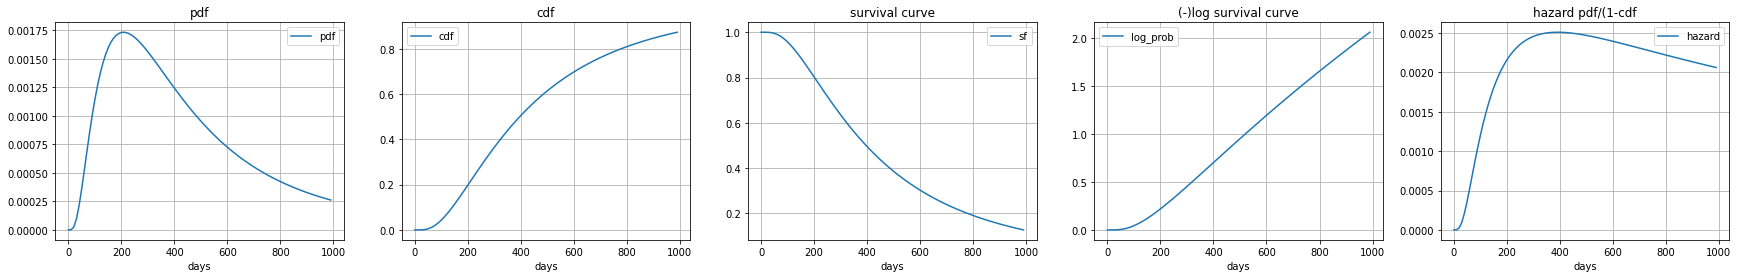

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
df_surv.plot.line(ax=ax[0], x='days', y='pdf', grid=True, title='pdf')
df_surv.plot.line(ax=ax[1], x='days', y='cdf', grid=True, title='cdf')
df_surv.plot.line(ax=ax[2], x='days', y='sf', grid=True, title='survival curve')
df_surv.plot.line(ax=ax[3], x='days', y='log_prob', grid=True, title='(-)log survival curve')
df_surv.plot.line(ax=ax[4], x='days', y='hazard', grid=True, title='hazard pdf/(1-cdf')

In [13]:
import os       
!pip install saspy

     |████████████████████████████████| 9.9 MB 6.9 MB/s 
  Created wheel for saspy: filename=saspy-3.7.8-py3-none-any.whl size=9919759 sha256=672c6f645c371568825fdd90da7c8912faf6ff1062b8f6813b7db1ea2cfafcb0
  Stored in directory: /root/.cache/pip/wheels/84/70/9c/4bdeac00500fff52f1f8717533d52e1d2fcd9a3b49f33fc864
Successfully built saspy


In [14]:
!java -version
!which java

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
/usr/bin/java


In [15]:
# For using SAS
import saspy
sas = saspy.SASsession(java='/usr/bin/java', iomhost=['odaws01-usw2.oda.sas.com',
        'odaws02-usw2.oda.sas.com','odaws03-usw2.oda.sas.com','odaws04-usw2.oda.sas.com'], iomport=8591, encoding='utf-8')
sas

Using SAS Config named: default
Please enter the IOM user id: jshi2@ford.com
Please enter the password for IOM user : ··········
SAS Connection established. Subprocess id is 240



Access Method         = IOM
SAS Config name       = default
SAS Config file       = /usr/local/lib/python3.7/dist-packages/saspy/sascfg.py
WORK Path             = /saswork/SAS_workE4E100012C21_odaws03-usw2.oda.sas.com/SAS_work5B8400012C21_odaws03-usw2.oda.sas.com/
SAS Version           = 9.04.01M6P11072018
SASPy Version         = 3.7.8
Teach me SAS          = False
Batch                 = False
Results               = Pandas
SAS Session Encoding  = utf-8
Python Encoding value = utf-8
SAS process Pid value = 76833


In [16]:
data_sas = sas.df2sd(data,table='data_sas',libref='work')

In [17]:
sas.submitLST("""
proc contents data=data_sas ;
run; quit;

""")

In [18]:
sas.submitLST("""
proc nlmixed data=data_sas ;
parms m1=1 s1=1;
pdf1=pdf('lognorml',days_censored,m1,s1);
cdf1=cdf('lognorml',days_censored,m1,s1);

if event=0 then do;
    ll1=log(1-cdf1); 
end;
else do;
    ll1=log(pdf1);
end;

model days_censored ~ general(ll1);
run;

""")

In [19]:
sas.endsas()

SAS Connection terminated. Subprocess id was 240
